## Exporting the results to PDF

Once you complete the assignments, export the entire notebook as PDF and attach it to your homework solutions. 
The best way of doing that is
1. Run all the cells of the notebook.
2. Export/download the notebook as PDF (File -> Download as -> PDF via LaTeX (.pdf)).
3. Concatenate your solutions for other tasks with the output of Step 2. On linux, you can use `pdfunite`, there are similar tools for other platforms, too. You can only upload a single PDF file to Moodle.

Make sure you are using `nbconvert` version 5.5 or later by running `jupyter nbconvert --version`. Older versions clip lines that exceed page width, which makes your code harder to grade.

# Matrix Factorization

In [1]:
import time
import scipy.sparse as sp
import numpy as np
from scipy.sparse.linalg import svds
from sklearn.linear_model import Ridge

import matplotlib.pyplot as plt
%matplotlib inline

## Restaurant recommendation

The goal of this task is to recommend restaurants to users based on the rating data in the Yelp dataset. For this, we try to predict the rating a user will give to a restaurant they have not yet rated based on a latent factor model.

Specifically, the objective function (loss) we wanted to optimize is:
$$
\mathcal{L} = \min_{P, Q} \sum_{(i, x) \in W} (M_{ix} - \mathbf{q}_i^T\mathbf{p}_x)^2 + \lambda\sum_x{\left\lVert \mathbf{p}_x  \right\rVert}^2 + \lambda\sum_i {\left\lVert\mathbf{q}_i  \right\rVert}^2
$$

where $W$ is the set of $(i, x)$ pairs for which the rating $M_{ix}$ given by user $i$ to restaurant $x$ is known. Here we have also introduced two regularization terms to help us with overfitting where $\lambda$ is hyper-parameter that control the strength of the regularization.

**Hint 1**: Using the closed form solution for regression might lead to singular values. To avoid this issue perform the regression step with an existing package such as scikit-learn. It is advisable to use ridge regression to account for regularization.

**Hint 2**: If you are using the scikit-learn package remember to set ``fit_intercept = False`` to only learn the coefficients of the linear regression.

### Load and Preprocess the Data (nothing to do here) 

In [2]:
ratings = np.load("exercise_12_matrix_factorization_ratings.npy")

In [3]:
# We have triplets of (user, restaurant, rating).
ratings

array([[101968,   1880,      1],
       [101968,    284,      5],
       [101968,   1378,      2],
       ...,
       [ 72452,   2100,      4],
       [ 72452,   2050,      5],
       [ 74861,   3979,      5]], dtype=int64)

Now we transform the data into a matrix of dimension [N, D], where N is the number of users and D is the number of restaurants in the dataset. We store the data as a sparse matrix to avoid out-of-memory issues.

In [4]:
n_users = np.max(ratings[:,0] + 1)
n_restaurants = np.max(ratings[:,1] + 1)
M = sp.coo_matrix((ratings[:,2], (ratings[:,0], ratings[:,1])), shape=(n_users, n_restaurants)).tocsr()
M

<337867x5899 sparse matrix of type '<class 'numpy.int64'>'
	with 929606 stored elements in Compressed Sparse Row format>

To avoid the <a href="https://en.wikipedia.org/wiki/Cold_start_(computing)"> cold start problem</a>, in the preprocessing step, we recursively remove all users and restaurants with 10 or less ratings.

Then, we randomly select 200 data points for the validation and test sets, respectively.

After this, we subtract the mean rating for each users to account for this global effect.

**Note**: Some entries might become zero in this process -- but these entries are different than the 'unknown' zeros in the matrix. We store the indices for which we the rating data available in a separate variable.

In [5]:
def cold_start_preprocessing(matrix, min_entries):
    """
    Recursively removes rows and columns from the input matrix which have less than min_entries nonzero entries.
    
    Parameters
    ----------
    matrix      : sp.spmatrix, shape [N, D]
                  The input matrix to be preprocessed.
    min_entries : int
                  Minimum number of nonzero elements per row and column.

    Returns
    -------
    matrix      : sp.spmatrix, shape [N', D']
                  The pre-processed matrix, where N' <= N and D' <= D
        
    """
    print("Shape before: {}".format(matrix.shape))
    
    shape = (-1, -1)
    while matrix.shape != shape:
        shape = matrix.shape
        nnz = matrix>0
        row_ixs = nnz.sum(1).A1 > min_entries
        matrix = matrix[row_ixs]
        nnz = matrix>0
        col_ixs = nnz.sum(0).A1 > min_entries
        matrix = matrix[:,col_ixs]
    print("Shape after: {}".format(matrix.shape))
    nnz = matrix>0
    assert (nnz.sum(0).A1 > min_entries).all()
    assert (nnz.sum(1).A1 > min_entries).all()
    return matrix

### Task 1: Implement a function that subtracts the mean user rating from the sparse rating matrix

In [6]:
def shift_user_mean(matrix):
    """
    Subtract the mean rating per user from the non-zero elements in the input matrix.
    
    Parameters
    ----------
    matrix : sp.spmatrix, shape [N, D]
             Input sparse matrix.
    Returns
    -------
    matrix : sp.spmatrix, shape [N, D]
             The modified input matrix.
    
    user_means : np.array, shape [N, 1]
                 The mean rating per user that can be used to recover the absolute ratings from the mean-shifted ones.

    """
    
    # TODO: Compute the modified matrix and user_means
    non_zeros = (matrix>0)
    user_means = matrix.sum(1) / non_zeros.sum(1)
    matrix -= sp.csr_matrix(user_means).multiply(non_zeros)
    
    assert np.all(np.isclose(matrix.mean(1), 0))
    return matrix, user_means

### Split the data into a train, validation and test set (nothing to do here)

In [7]:
def split_data(matrix, n_validation, n_test):
    """
    Extract validation and test entries from the input matrix. 
    
    Parameters
    ----------
    matrix          : sp.spmatrix, shape [N, D]
                      The input data matrix.
    n_validation    : int
                      The number of validation entries to extract.
    n_test          : int
                      The number of test entries to extract.

    Returns
    -------
    matrix_split    : sp.spmatrix, shape [N, D]
                      A copy of the input matrix in which the validation and test entries have been set to zero.
    
    val_idx         : tuple, shape [2, n_validation]
                      The indices of the validation entries.
    
    test_idx        : tuple, shape [2, n_test]
                      The indices of the test entries.
    
    val_values      : np.array, shape [n_validation, ]
                      The values of the input matrix at the validation indices.
                      
    test_values     : np.array, shape [n_test, ]
                      The values of the input matrix at the test indices.

    """
    
    matrix_cp = matrix.copy()
    non_zero_idx = np.argwhere(matrix_cp)
    ixs = np.random.permutation(non_zero_idx)
    val_idx = tuple(ixs[:n_validation].T)
    test_idx = tuple(ixs[n_validation:n_validation + n_test].T)
    
    val_values = matrix_cp[val_idx].A1
    test_values = matrix_cp[test_idx].A1
    
    matrix_cp[val_idx] = matrix_cp[test_idx] = 0
    matrix_cp.eliminate_zeros()

    return matrix_cp, val_idx, test_idx, val_values, test_values

In [8]:
M = cold_start_preprocessing(M, 20)

Shape before: (337867, 5899)
Shape after: (3529, 2072)


In [9]:
n_validation = 200
n_test = 200
# Split data
M_train, val_idx, test_idx, val_values, test_values = split_data(M, n_validation, n_test)

In [10]:
# Remove user means.
nonzero_indices = np.argwhere(M_train)
M_shifted, user_means = shift_user_mean(M_train)
# Apply the same shift to the validation and test data.
val_values_shifted = val_values - user_means[np.array(val_idx).T[:,0]].A1
test_values_shifted = test_values - user_means[np.array(test_idx).T[:,0]].A1

### Compute the loss function (nothing to do here)

In [11]:
def loss(values, ixs, Q, P, reg_lambda):
    """
    Compute the loss of the latent factor model (at indices ixs).
    Parameters
    ----------
    values : np.array, shape [n_ixs,]
        The array with the ground-truth values.
    ixs : tuple, shape [2, n_ixs]
        The indices at which we want to evaluate the loss (usually the nonzero indices of the unshifted data matrix).
    Q : np.array, shape [N, k]
        The matrix Q of a latent factor model.
    P : np.array, shape [k, D]
        The matrix P of a latent factor model.
    reg_lambda : float
        The regularization strength
          
    Returns
    -------
    loss : float
           The loss of the latent factor model.

    """
    mean_sse_loss = np.sum((values - Q.dot(P)[ixs])**2)
    regularization_loss =  reg_lambda * (np.sum(np.linalg.norm(P, axis=0)**2) + np.sum(np.linalg.norm(Q, axis=1) ** 2))
    
    return mean_sse_loss + regularization_loss

## Alternating optimization

In the first step, we will approach the problem via alternating optimization, as learned in the lecture. That is, during each iteration you first update $Q$ while having $P$ fixed and then vice versa.

### Task 2: Implement a function that initializes the latent factors $Q$ and $P$

In [12]:
def initialize_Q_P(matrix, k, init='random'):
    """
    Initialize the matrices Q and P for a latent factor model.
    
    Parameters
    ----------
    matrix : sp.spmatrix, shape [N, D]
             The matrix to be factorized.
    k      : int
             The number of latent dimensions.
    init   : str in ['svd', 'random'], default: 'random'
             The initialization strategy. 'svd' means that we use SVD to initialize P and Q, 'random' means we initialize
             the entries in P and Q randomly in the interval [0, 1).

    Returns
    -------
    Q : np.array, shape [N, k]
        The initialized matrix Q of a latent factor model.

    P : np.array, shape [k, D]
        The initialized matrix P of a latent factor model.
    """
    np.random.seed(0)
    
    N, D = matrix.shape
    if init == 'svd':
        U, s, V = svds(matrix, k=k)
        S = np.diag(s)
        Q = U.dot(S)
        P = V
    else:
        Q = np.random.random((N, k))
        P = np.random.random((k, D))
        
    assert Q.shape == (matrix.shape[0], k)
    assert P.shape == (k, matrix.shape[1])
    return Q, P

### Task 3: Implement the alternating optimization approach 

In [15]:
def latent_factor_alternating_optimization(M, non_zero_idx, k, val_idx, val_values,
                                           reg_lambda, max_steps=100, init='random',
                                           log_every=1, patience=5, eval_every=1):
    """
    Perform matrix factorization using alternating optimization. Training is done via patience,
    i.e. we stop training after we observe no improvement on the validation loss for a certain
    amount of training steps. We then return the best values for Q and P oberved during training.
    
    Parameters
    ----------
    M                 : sp.spmatrix, shape [N, D]
                        The input matrix to be factorized.
                      
    non_zero_idx      : np.array, shape [nnz, 2]
                        The indices of the non-zero entries of the un-shifted matrix to be factorized. 
                        nnz refers to the number of non-zero entries. Note that this may be different
                        from the number of non-zero entries in the input matrix M, e.g. in the case
                        that all ratings by a user have the same value.
    
    k                 : int
                        The latent factor dimension.
    
    val_idx           : tuple, shape [2, n_validation]
                        Tuple of the validation set indices.
                        n_validation refers to the size of the validation set.
                      
    val_values        : np.array, shape [n_validation, ]
                        The values in the validation set.
                      
    reg_lambda        : float
                        The regularization strength.
                      
    max_steps         : int, optional, default: 100
                        Maximum number of training steps. Note that we will stop early if we observe
                        no improvement on the validation error for a specified number of steps
                        (see "patience" for details).
                      
    init              : str in ['random', 'svd'], default 'random'
                        The initialization strategy for P and Q. See function initialize_Q_P for details.
    
    log_every         : int, optional, default: 1
                        Log the training status every X iterations.
                    
    patience          : int, optional, default: 5
                        Stop training after we observe no improvement of the validation loss for X evaluation
                        iterations (see eval_every for details). After we stop training, we restore the best 
                        observed values for Q and P (based on the validation loss) and return them.
                      
    eval_every        : int, optional, default: 1
                        Evaluate the training and validation loss every X steps. If we observe no improvement
                        of the validation error, we decrease our patience by 1, else we reset it to *patience*.

    Returns
    -------
    best_Q            : np.array, shape [N, k]
                        Best value for Q (based on validation loss) observed during training
                      
    best_P            : np.array, shape [k, D]
                        Best value for P (based on validation loss) observed during training
                      
    validation_losses : list of floats
                        Validation loss for every evaluation iteration, can be used for plotting the validation
                        loss over time.
                        
    train_losses      : list of floats
                        Training loss for every evaluation iteration, can be used for plotting the training
                        loss over time.                     
    
    converged_after   : int
                        it - patience*eval_every, where it is the iteration in which patience hits 0,
                        or -1 if we hit max_steps before converging. 

    """
    
    Q,P = initialize_Q_P(M, k, init)
    best_Q = Q
    best_P = P
    best_loss = -1
    validation_losses = []
    train_losses = []
    converged_after = -1
    train_idx = tuple(non_zero_idx.T)
    
    reg = Ridge(alpha=reg_lambda, fit_intercept=False)
    
    nnz_mask = sp.coo_matrix((np.ones(len(non_zero_idx)),
                              (non_zero_idx[:,0],non_zero_idx[:,1])),
                             shape=M.shape, dtype="uint8").tocsr()
    rows = nnz_mask.tolil().rows
    cols = nnz_mask.T.tolil().rows
    
    for i in range(max_steps):
        if i % eval_every == 0:
            # evaluate losses
            val_loss = loss(val_values, val_idx, Q, P, reg_lambda)
            validation_losses.append(val_loss)
            
            train_loss = loss(M[train_idx].A1, train_idx, Q, P, reg_lambda)
            train_losses.append(train_loss)

            if best_loss <= -1 or val_loss < best_loss:
                best_Q = Q
                best_P = P
                best_loss = val_loss
                current_patience = patience
            else:
                current_patience -= 1

            if current_patience == 0:
                converged_after = i - patience * eval_every
                break  
                
        print("Iteration ", i)
        
        # fix Q
        for rating_idx in range(M.shape[1]):
            nnz_idx = cols[rating_idx]
            res = reg.fit(Q[nnz_idx], np.squeeze(M[nnz_idx, rating_idx].toarray()))
            P[:, rating_idx] = res.coef_

        # fix P 
        for user_idx in range(M.shape[0]):
            nnz_idx = rows[user_idx]
            res = reg.fit(P[:, nnz_idx].T, np.squeeze(M[user_idx, nnz_idx].toarray()))
            Q[user_idx, :] = res.coef_
    
    return best_Q, best_P, validation_losses, train_losses, converged_after

### Train the latent factor (nothing to do here)

In [16]:
Q, P, val_loss, train_loss, converged = latent_factor_alternating_optimization(M_shifted, nonzero_indices, 
                                                                               k=100, val_idx=val_idx,
                                                                               val_values=val_values_shifted, 
                                                                               reg_lambda=1e-4, init='random',
                                                                               max_steps=100, patience=10)

Iteration  0
Iteration  1
Iteration  2
Iteration  3
Iteration  4
Iteration  5
Iteration  6
Iteration  7
Iteration  8
Iteration  9
Iteration  10
Iteration  11
Iteration  12
Iteration  13
Iteration  14
Iteration  15
Iteration  16
Iteration  17
Iteration  18
Iteration  19
Iteration  20
Iteration  21
Iteration  22
Iteration  23
Iteration  24
Iteration  25
Iteration  26
Iteration  27
Iteration  28
Iteration  29
Iteration  30
Iteration  31
Iteration  32
Iteration  33
Iteration  34
Iteration  35
Iteration  36
Iteration  37
Iteration  38
Iteration  39
Iteration  40
Iteration  41
Iteration  42
Iteration  43
Iteration  44
Iteration  45
Iteration  46
Iteration  47
Iteration  48
Iteration  49
Iteration  50
Iteration  51
Iteration  52
Iteration  53
Iteration  54
Iteration  55
Iteration  56
Iteration  57
Iteration  58
Iteration  59
Iteration  60
Iteration  61
Iteration  62
Iteration  63
Iteration  64
Iteration  65
Iteration  66
Iteration  67
Iteration  68
Iteration  69
Iteration  70
Iteration  71
It

### Plot the validation and training losses over for each iteration (nothing to do here)

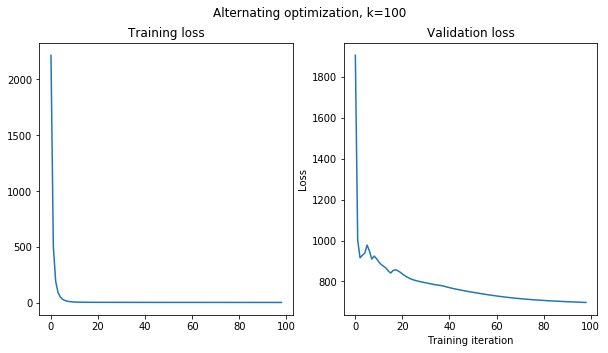

In [17]:
fig, ax = plt.subplots(1, 2, figsize=[10, 5])
fig.suptitle("Alternating optimization, k=100")

ax[0].plot(train_loss[1::])
ax[0].set_title('Training loss')
plt.xlabel("Training iteration")
plt.ylabel("Loss")


ax[1].plot(val_loss[1::])
ax[1].set_title('Validation loss')
plt.xlabel("Training iteration")
plt.ylabel("Loss")

plt.show()